In [1]:
import spinup
from spinup.utils.run_utils import ExperimentGrid
from spinup.utils.serialization_utils import convert_json
import argparse
import gym
import json
import os, subprocess, sys
import os.path as osp
import string
import tensorflow as tf
from textwrap import dedent


# Command line args that will go to ExperimentGrid.run, and must possess unique
# values (therefore must be treated separately).
RUN_KEYS = ['num_cpu', 'data_dir', 'datestamp']

# Command line sweetener, allowing short-form flags for common, longer flags.
SUBSTITUTIONS = {'env': 'env_name',
                 'hid': 'ac_kwargs:hidden_sizes',
                 'act': 'ac_kwargs:activation',
                 'cpu': 'num_cpu',
                 'dt': 'datestamp'}

# Only some algorithms can be parallelized (have num_cpu > 1):
MPI_COMPATIBLE_ALGOS = ['vpg', 'trpo', 'ppo']


def friendly_err(err_msg):
    # add whitespace to error message to make it more readable
    return '\n\n' + err_msg + '\n\n'


def parse_and_execute_grid_search(cmd, args):
    """Interprets algorithm name and cmd line args into an ExperimentGrid."""

    # Parse which algorithm to execute
    algo = eval('spinup.'+cmd)

    # Before all else, check to see if any of the flags is 'help'.
    valid_help = ['--help', '-h', 'help']
    if any([arg in valid_help for arg in args]):
        print('\n\nShowing docstring for spinup.'+cmd+':\n')
        print(algo.__doc__)
        sys.exit()

    def process(arg):
        # Process an arg by eval-ing it, so users can specify more
        # than just strings at the command line (eg allows for
        # users to give functions as args).
        try:
            return eval(arg)
        except:
            return arg

    # Make first pass through args to build base arg_dict. Anything
    # with a '--' in front of it is an argument flag and everything after,
    # until the next flag, is a possible value.
    arg_dict = dict()
    for i, arg in enumerate(args):
        assert i > 0 or '--' in arg, \
            friendly_err("You didn't specify a first flag.")
        if '--' in arg:
            arg_key = arg.lstrip('-')
            arg_dict[arg_key] = []
        else:
            arg_dict[arg_key].append(process(arg))

    # Make second pass through, to catch flags that have no vals.
    # Assume such flags indicate that a boolean parameter should have
    # value True.
    for k,v in arg_dict.items():
        if len(v)==0:
            v.append(True)

    # Third pass: check for user-supplied shorthands, where a key has
    # the form --keyname[kn]. The thing in brackets, 'kn', is the
    # shorthand. NOTE: modifying a dict while looping through its
    # contents is dangerous, and breaks in 3.6+. We loop over a fixed list
    # of keys to avoid this issue.
    given_shorthands = dict()
    fixed_keys = list(arg_dict.keys())
    for k in fixed_keys:
        p1, p2 = k.find('['), k.find(']')
        if p1 >= 0 and p2 >= 0:
            # Both '[' and ']' found, so shorthand has been given
            k_new = k[:p1]
            shorthand = k[p1+1:p2]
            given_shorthands[k_new] = shorthand
            arg_dict[k_new] = arg_dict[k]
            del arg_dict[k]

    # Penultimate pass: sugar. Allow some special shortcuts in arg naming,
    # eg treat "env" the same as "env_name". This is super specific
    # to Spinning Up implementations, and may be hard to maintain.
    # These special shortcuts are described by SUBSTITUTIONS.
    for special_name, true_name in SUBSTITUTIONS.items():
        if special_name in arg_dict:
            # swap it in arg dict
            arg_dict[true_name] = arg_dict[special_name]
            del arg_dict[special_name]

        if special_name in given_shorthands:
            # point the shortcut to the right name
            given_shorthands[true_name] = given_shorthands[special_name]
            del given_shorthands[special_name]

    # Final pass: check for the special args that go to the 'run' command
    # for an experiment grid, separate them from the arg dict, and make sure
    # that they have unique values. The special args are given by RUN_KEYS.
    run_kwargs = dict()
    for k in RUN_KEYS:
        if k in arg_dict:
            val = arg_dict[k]
            assert len(val)==1, \
                friendly_err("You can only provide one value for %s."%k)
            run_kwargs[k] = val[0]
            del arg_dict[k]

    # Determine experiment name. If not given by user, will be determined
    # by the algorithm name.
    if 'exp_name' in arg_dict:
        assert len(arg_dict['exp_name'])==1, \
            friendly_err("You can only provide one value for exp_name.")
        exp_name = arg_dict['exp_name'][0]
        del arg_dict['exp_name']
    else:
        exp_name = 'cmd_' + cmd

    # Make sure that if num_cpu > 1, the algorithm being used is compatible
    # with MPI.
    if 'num_cpu' in run_kwargs and not(run_kwargs['num_cpu'] == 1):
        assert cmd in MPI_COMPATIBLE_ALGOS, \
            friendly_err("This algorithm can't be run with num_cpu > 1.")

    # Special handling for environment: make sure that env_name is a real,
    # registered gym environment.
    valid_envs = [e.id for e in list(gym.envs.registry.all())]
    assert 'env_name' in arg_dict, \
        friendly_err("You did not give a value for --env_name! Add one and try again.")
    for env_name in arg_dict['env_name']:
        err_msg = dedent("""

            %s is not registered with Gym.

            Recommendations:

                * Check for a typo (did you include the version tag?)

                * View the complete list of valid Gym environments at

                    https://gym.openai.com/envs/

            """%env_name)
        assert env_name in valid_envs, err_msg


    # Construct and execute the experiment grid.
    eg = ExperimentGrid(name=exp_name)
    for k,v in arg_dict.items():
        eg.add(k, v, shorthand=given_shorthands.get(k))
    eg.run(algo, **run_kwargs)


In [2]:
import time
import joblib
import os
import os.path as osp
import tensorflow as tf
from spinup import EpochLogger
from spinup.utils.logx import restore_tf_graph

def load_policy(fpath, itr='last', deterministic=False):

    # handle which epoch to load from
    if itr=='last':
        saves = [int(x[11:]) for x in os.listdir(fpath) if 'simple_save' in x and len(x)>11]
        itr = '%d'%max(saves) if len(saves) > 0 else ''
    else:
        itr = '%d'%itr

    # load the things!
    sess = tf.Session()
    model = restore_tf_graph(sess, osp.join(fpath, 'simple_save'+itr))

    # get the correct op for executing actions
    if deterministic and 'mu' in model.keys():
        # 'deterministic' is only a valid option for SAC policies
        print('Using deterministic action op.')
        action_op = model['mu']
    else:
        print('Using default action op.')
        action_op = model['pi']

    # make function for producing an action given a single state
    get_action = lambda x : sess.run(action_op, feed_dict={model['x']: x[None,:]})[0]

    # try to load environment from save
    # (sometimes this will fail because the environment could not be pickled)
    try:
        state = joblib.load(osp.join(fpath, 'vars'+itr+'.pkl'))
        env = state['env']
    except:
        env = None

    return env, get_action


from IPython import display
import matplotlib
import matplotlib.pyplot as plt


def run_policy(env, get_action, max_ep_len=None, num_episodes=100, render=True):

    assert env is not None, \
        "Environment not found!\n\n It looks like the environment wasn't saved, " + \
        "and we can't run the agent in it. :( \n\n Check out the readthedocs " + \
        "page on Experiment Outputs for how to handle this situation."

    logger = EpochLogger()
    o, r, d, ep_ret, ep_len, n = env.reset(), 0, False, 0, 0, 0
    
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once

    
    while n < num_episodes:
        if render:
            img.set_data(env.render(mode='rgb_array')) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
#            time.sleep(1e-3)

        a = get_action(o)
        o, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1

        if d or (ep_len == max_ep_len):
            logger.store(EpRet=ep_ret, EpLen=ep_len)
            print('Episode %d \t EpRet %.3f \t EpLen %d'%(n, ep_ret, ep_len))
            o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
            n += 1

    logger.log_tabular('EpRet', with_min_and_max=True)
    logger.log_tabular('EpLen', average_only=True)
    logger.dump_tabular()

In [3]:
%matplotlib inline

Episode 1 	 EpRet 205.794 	 EpLen 474
-------------------------------------
|    AverageEpRet |             228 |
|        StdEpRet |            21.9 |
|        MaxEpRet |             250 |
|        MinEpRet |             206 |
|           EpLen |             592 |
-------------------------------------


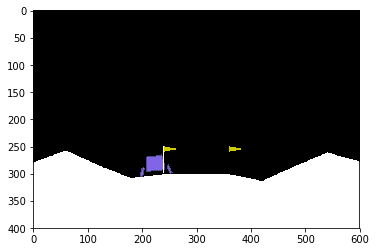

In [7]:
fpath = '/app/spinningup/data/installtest/installtest_s0'
env, get_action = load_policy(fpath, 
                              'last',
                              True)
run_policy(env, get_action, 0, 2, True)